# Energy Trading Insights
Data Analysis of Singapore's Wholesale Electricity Market

# 1. Introduction<a id=introduction></a>
As part of my project on energy trading and market analysis, I analysed the Uniform Singapore Energy Price (USEP). The USEP is the wholesale electricity price in Singapore's National Electricity Market (NEM), which is determined through a market clearing mechanism that matches supply and demand. In this process, suppliers submit bids indicating the amount of electricity they are willing to produce and at what price. These bids are then ordered from lowest to highest price, creating a cumulative volume-price curve, known as a 'merit order' curve.

For example, if demand is 7000 MW in a given 30-minute period, the final USEP price would be \\$4000 per MWh. Conversely, if the demand is 4000 MW, the price could drop to around \\$0/MWh, demonstrating that the final energy price is set by the most expensive generator needed to meet the demand.

Using the merit order data published by the market authority, I constructed analytical models to estimate USEP prices based on the merit order and demand per period. This approach is critical for optimising bidding strategies for Battery Energy Storage Systems (BESS) and other market participants. My analysis involved data cleaning, outlier handling and the use of advanced data manipulation tools such as Polars and DuckDB to ensure efficient processing of large datasets.

In this project, I aimed to provide data-driven insights into energy trading and market operations, focusing on how changes in demand affect market clearing prices. This work is essential for developing effective bidding strategies and optimising energy storage systems in Singapore's dynamic electricity market.

## Input data:

- Merit order: “DelayedOfferStacks_Energy_01-Jan-2023 to 31-Jan-2023.csv”
- Demand [DEMAND] & final prices [USEP]: [USEP_Jan-2023.csv](https://github.com/romanwolf-git/energy_trading_insights/blob/main/03_USEP_Jan-2023.csv)

## Table of Contents
1. [Introduction](#introduction)
2. [Data Cleaning](#data-cleaning)
3. [Plotting Merit Order](#plotting-merit-order)
4. [Final Clearing Price Function](#final-clearing-price-function)
5. [Unit Testing](#unit-testing)
6. [Clearing Price for Complete Month](#complete-month)
7. [Comparison of Calculated and Actual Price](#comparison)
8. [SQL Implementation](#sql)

In [43]:
# install relevant libraries
!pip install polars seaborn matplotlib duckdb pytest ipytest --quiet

In [2]:
from datetime import datetime, timedelta
from pathlib import Path

import duckdb
import ipytest
import matplotlib.pyplot as plt
import polars as pl
import pytest
import seaborn as sns

ipytest.autoconfig()

# 2. Data Cleaning<a id=data-cleaning></a>

For data manipulation, I decided to use the Polars library instead of the more common Pandas. This decision was based on the superior performance of Polars, as it's built on Rust rather than NumPy. Polars, along with DuckDB, is known for its exceptional speed in handling large datasets.

I implemented code to clean up the data files, paying close attention to potential data gaps and outliers. To ensure consistency, I standardised all column names to follow a lower-case, underscore-separated format (e.g. 'demand', 'bid_volume').

A key component of my pre-processing was to develop a function to create a datetime index based on the date and period columns. This function was essential in aligning the merit order and demand data in time, allowing for a more accurate analysis of price dynamics over time.

In [3]:
def print_df_info(df: pl.DataFrame, name: str)-> None:
    """Function that prints basic information about a DataFrame"""
    print(f"{80*'-'}\nDataFrame: {name}\n{80*'-'}")
    print(f"Shape: {df.shape}")
    print("Head:\n", df.head())
    print("Tail:\n", df.tail())
    print("Description:\n", df.describe())

# Load both files
df_order = pl.read_csv('02_DelayedOfferStacks_Energy_01-Jan-2023 to 31-Jan-2023.csv', skip_rows=2)
df_demand = pl.read_csv('03_USEP_Jan-2023.csv')

# Print basic data info for each DataFrame
print_df_info(df_order, "Order Data")
print_df_info(df_demand, "Demand Data")

--------------------------------------------------------------------------------
DataFrame: Order Data
--------------------------------------------------------------------------------
Shape: (206578, 4)
Head:
 shape: (5, 4)
┌─────────────┬────────┬─────────────────────────────────┬─────────────────────────────────┐
│ Date        ┆ Period ┆ Lowest to Highest Offer Price … ┆ Total Offer Capacity At Specif… │
│ ---         ┆ ---    ┆ ---                             ┆ ---                             │
│ str         ┆ i64    ┆ f64                             ┆ f64                             │
╞═════════════╪════════╪═════════════════════════════════╪═════════════════════════════════╡
│ 01-JAN-2023 ┆ 1      ┆ -4750.0                         ┆ 84.3                            │
│ 01-JAN-2023 ┆ 1      ┆ -4500.0                         ┆ 324.0                           │
│ 01-JAN-2023 ┆ 1      ┆ -90.0                           ┆ 854.0                           │
│ 01-JAN-2023 ┆ 1      ┆ -67.0  

## Summary of the short inspection
- Not all information is necessary for the given task, i.e. some columns can be omitted.
- The date formats are different in the two files. This must be taken into account for the function.
- The date columns both contain values from 2023-01-01 (min) to 2023-01-21 (max).
- The period columns correctly contain values from 1 (min) to 48 (max).
- Missing data: The last row of the merit order table of bid prices and volumes is missing values.
- Data formats are given in the descriptions.

## Rename columns

In [4]:
# rename columns to match specified lowercase underscore formatting
df_order = df_order.rename(
    {'Date':'date',
     'Period': 'period',
     'Lowest to Highest Offer Price ($/MWh)': 'bid_price',
     'Total Offer Capacity At Specified Offer Price (MW)': 'bid_volume'}
)
print(df_order.columns)

df_demand = df_demand.rename(
    {'INFORMATION TYPE': 'information_type',
     'DATE':'date',
     'PERIOD': 'period',
     'USEP ($/MWh)': 'actual_price',
     'LCP ($/MWh)': 'lcp',
     'DEMAND (MW)': 'demand',
     'TCL (MW)': 'tcl'}
)
print(df_demand.columns)

['date', 'period', 'bid_price', 'bid_volume']
['information_type', 'date', 'period', 'actual_price', 'lcp', 'demand', 'tcl']


## Fixing dates
Since Polars doesn't use indexes, creating a datetime index can be described as creating a datetime column. This column can then be filtered for datetimes including hours and minutes. Instead of writing one complex function, I wrote 2 smaller, separate functions to improve the readability of the code.

In [5]:
def period_to_time(period: int) -> str:
    '''Calculates hour of day from period'''
    # Calculate the hour and minute
    hour = (period - 1) // 2
    minute = (period - 1) % 2 * 30
    
    # Format the hour and minute as a string
    return f"{hour:02d}:{minute:02d}"

def create_datetime_column(df: pl.DataFrame) -> pl.DataFrame:
    """Creates a datetime column from a date and period column"""
    if 'date' in df.columns:  
        # get datetime format
        test_date = df.select(pl.col('date'))[0].item()
        try:
            datetime.strptime(test_date, '%d %b %Y')
            format = "%d %b %Y %H:%M"
        except ValueError:
            format = "%d-%b-%Y %H:%M"

        # return converted datetime column
        return df.with_columns(
            pl.concat_str(
                [pl.col('date'),
                 pl.col('period').map_elements(period_to_time, return_dtype=str)],
                separator=" ",
            ).alias('datetime').str.to_datetime(format)
        )
    else:
        raise ValueError("The DataFrame does not contain a 'date' column")

In [6]:
df_order = create_datetime_column(df_order)
print(df_order.head(1))
df_demand = create_datetime_column(df_demand)
print(df_demand.head(1))

shape: (1, 5)
┌─────────────┬────────┬───────────┬────────────┬─────────────────────┐
│ date        ┆ period ┆ bid_price ┆ bid_volume ┆ datetime            │
│ ---         ┆ ---    ┆ ---       ┆ ---        ┆ ---                 │
│ str         ┆ i64    ┆ f64       ┆ f64        ┆ datetime[μs]        │
╞═════════════╪════════╪═══════════╪════════════╪═════════════════════╡
│ 01-JAN-2023 ┆ 1      ┆ -4750.0   ┆ 84.3       ┆ 2023-01-01 00:00:00 │
└─────────────┴────────┴───────────┴────────────┴─────────────────────┘
shape: (1, 8)
┌──────────────────┬─────────────┬────────┬──────────────┬─────┬──────────┬─────┬──────────────┐
│ information_type ┆ date        ┆ period ┆ actual_price ┆ lcp ┆ demand   ┆ tcl ┆ datetime     │
│ ---              ┆ ---         ┆ ---    ┆ ---          ┆ --- ┆ ---      ┆ --- ┆ ---          │
│ str              ┆ str         ┆ i64    ┆ f64          ┆ f64 ┆ f64      ┆ f64 ┆ datetime[μs] │
╞══════════════════╪═════════════╪════════╪══════════════╪═════╪══════════╪═════

## Drop irrelevant data and rearrange columns

In [7]:
df_order = (df_order.drop('date', 'period')
            .select('datetime', 'bid_price', 'bid_volume'))
df_demand = (df_demand.drop('information_type', 'date', 'period', 'lcp', 'tcl')
            .select('datetime', 'actual_price', 'demand'))

## Check for duplicate rows

In [8]:
print(df_order.group_by(df_order.columns).agg(pl.len())
 .filter(pl.col('len') > 1)
)
print(df_demand.group_by(df_demand.columns).agg(pl.len())
 .filter(pl.col('len') > 1)
)

shape: (0, 4)
┌──────────────┬───────────┬────────────┬─────┐
│ datetime     ┆ bid_price ┆ bid_volume ┆ len │
│ ---          ┆ ---       ┆ ---        ┆ --- │
│ datetime[μs] ┆ f64       ┆ f64        ┆ u32 │
╞══════════════╪═══════════╪════════════╪═════╡
└──────────────┴───────────┴────────────┴─────┘
shape: (0, 4)
┌──────────────┬──────────────┬────────┬─────┐
│ datetime     ┆ actual_price ┆ demand ┆ len │
│ ---          ┆ ---          ┆ ---    ┆ --- │
│ datetime[μs] ┆ f64          ┆ f64    ┆ u32 │
╞══════════════╪══════════════╪════════╪═════╡
└──────────────┴──────────────┴────────┴─────┘


## Drop missing data

In [9]:
# drop last row as mentioned above
df_order = df_order.drop_nulls()

## Inspect time consistency

In [10]:
# extract sorted datetime from df_order
df_sorted = df_order.sort('datetime')

# subtract datetime shifted by 1 from datetime
df_sorted.with_columns(
    (df_sorted['datetime'] - df_sorted['datetime'].shift()).alias('time_diff')
).group_by('time_diff').agg(pl.len().alias('count'))

time_diff,count
duration[μs],u32
0µs,205089
null,1
30m,1487


For 1487 dates there is a consistent "30m" interval. There is one occurrence of "null" in the first row, indicating that there is no previous date to compare. The "0µs" differences represent identical date-time values for different bids. There are no other gaps, indicating that the data is complete and consistent.

In [11]:
# extract sorted datetime from df_order
df_sorted = df_demand.sort('datetime')

# subtract datetime shifted by 1 from datetime
df_sorted.with_columns(
    (df_sorted['datetime'] - df_sorted['datetime'].shift()).alias('time_diff')
).group_by('time_diff').agg(pl.len().alias('count'))

time_diff,count
duration[μs],u32
30m,1485
1h,1
null,1


There is a consistent 30 minute interval for 1485 dates. There is one occurrence of "null" in the first row, indicating that there is no previous date to compare. A difference of 1 hour indicates a single gap in the data.

In [12]:
# inspect the relevant rows
start_time = datetime(2023, 1, 22, 7)
end_time = start_time - timedelta(hours=1)

df_demand.filter(
    (pl.col('datetime') <= start_time) & (pl.col('datetime') >= end_time)
)

datetime,actual_price,demand
datetime[μs],f64,f64
2023-01-22 06:00:00,111.85,5277.444
2023-01-22 07:00:00,112.03,5357.074


There is no data on the actual price and demand at 6:30, so a merit order cannot be created for that time. While the missing data can be imputed, this process may introduce errors. I have chosen to use forward filling to deal with the missing values, but the values can also be found online (actual price \\$111.91/MWh and demand 5316.205 MW, [see cf.](https://www.nems.emcsg.com/nems-prices)).

In [13]:
# Upsample by filling null values forward every 30 minutes
df_demand = df_demand.upsample(
    time_column='datetime', 
    every='30m'
).fill_null(strategy='forward')

# get shape
df_demand.shape

(1488, 3)

## Inspect distributions and outliers

In [14]:
def plot_histograms(df: pl.DataFrame)->None:
    """plot histograms for the distributions of the features"""
    # Plot to check for outliers
    fig, axes = plt.subplots(1,2, figsize=(8,3))
    fig.subplots_adjust(wspace=0.25)

    for ax, col in zip(axes, df.columns[1:]):
        sns.histplot(data=df, x=col, ax=ax, bins=100)

        ax.set_title(f'Histogram {col.replace("_", " ")}', loc='left')
        ax.set_xlabel(f'{col.replace("_", " ").capitalize()}')
        ax.set_ylabel('Frequency')

    # Display the plot
    plt.show()

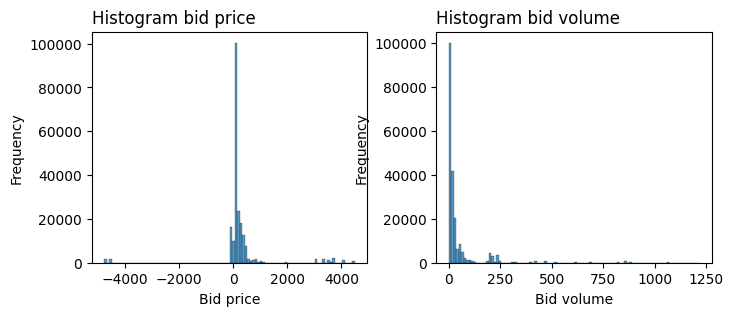

In [15]:
plot_histograms(df_order)

The visualisation shows that the bid price is not normally distributed, with a few values below -4000 and above +4000. The bid volume is also not normally distributed and right skewed, with outliers ranging approximately from over 250 MW to over 1000 MW.

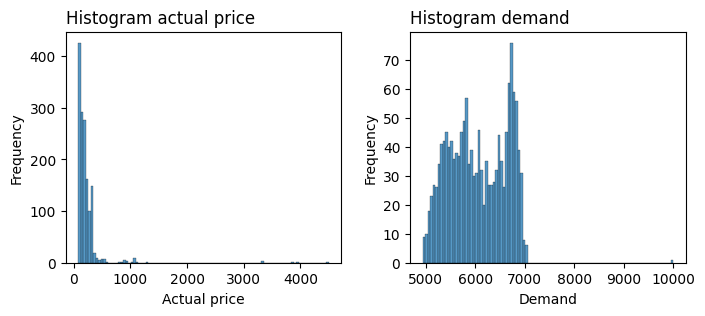

In [16]:
plot_histograms(df_demand)

The visualisations show that both characteristics are not normally distributed and contain outliers, such as instances of very high demand or very high prices. Demand is left skewed while the actual price is right skewed.

Depending on the task, it may be advisable to remove outliers (e.g. z-scores above 3). At this point, it makes sense to check whether the demand can be met by the current cumulative bids. This could be relevant for the example of an almost 10,000 MW demand.

In [17]:
for date_time in df_demand['datetime']:
    demand = (df_demand.filter(pl.col('datetime') == date_time)
              .select('demand').item())
    cum_bid_volume = (df_order.filter(pl.col('datetime') == date_time)
                      .select('bid_volume').sum().item())
    if demand > cum_bid_volume:
        print(f'At {date_time} the demand ({round(demand,1)} MW) is larger than the cumulated bid volume ({round(cum_bid_volume, 1)} MW)')

At 2023-01-15 00:00:00 the demand (9999.0 MW) is larger than the cumulated bid volume (6635.5 MW)


In [18]:
# inspect values of an hour before and after the irregular high demand
df_demand.filter((pl.col('datetime') >= datetime(2023,1,14,23,0)) & (pl.col('datetime') < datetime(2023,1,15,1,30)))

datetime,actual_price,demand
datetime[μs],f64,f64
2023-01-14 23:00:00,195.48,6005.157
2023-01-14 23:30:00,177.22,5890.857
2023-01-15 00:00:00,187.64,9999.023
2023-01-15 00:30:00,177.12,5739.838
2023-01-15 01:00:00,187.54,5709.963


The price at 2023-01-15 00:00:00 is still relatively in line with previous prices. It seems that only the demand has an error. I will replace the erroneous value with a looked-up value ([see cf.]('https://www.nems.emcsg.com/nems-prices')).

In [19]:
df_demand = (df_demand
             .with_columns(
                 demand=pl.when(pl.col('datetime')==datetime(2023,1,15,0,0))
                 .then(pl.lit(5797.023))
                 .otherwise(pl.col('demand'))))

In [20]:
# suggestion for z-score outlier removal
def z_score_cleaning(df: pl.DataFrame, col: str, threshold=3)-> pl.DataFrame:
    """
    removes outliers based on z-score and threhshold
    """
    # Compute z-score for respective column
    df = df.with_columns((
        (pl.col(col) - pl.col(col).mean())/ pl.col(col).std()
    ).alias('z_score'))

    # Remove outliers based on the threshold
    df = df.filter(pl.col(f'z_score') <= threshold)

    # drop 'z_score'
    df = df.drop(f'z_score')
    return df

# 3. Plotting Merit Order<a id=plotting-merit-order></a>

I wrote a function to visualise the merit order curve for a given time period in the Singapore electricity market. This function is crucial because the merit order is recalculated for every 30-minute interval (5 minutes in Australia), reflecting the constantly changing bids from power suppliers.

The function takes three main inputs:
1. The merit order data (df_order)
2. The demand data (df_demand)
3. A specific date/time to filter the data

By plotting the merit order for a single period, we can observe how the supply curve intersects with the demand curve to determine the market clearing price. This visualisation is essential for basic modelling of price formation in the energy market and can provide valuable insights for optimising bidding strategies, especially for Battery Energy Storage Systems (BESS).

This analytical tool I have created is particularly useful for energy trading analysis, as it allows a detailed examination of market dynamics at any given time. It can help identify patterns in bidding behaviour, assess the impact of demand fluctuations on prices, and inform data-driven decision making in energy trading operations.

In [21]:
def plot_merit_order(df_order: pl.DataFrame, df_demand: pl.DataFrame, filter_datetime: datetime.date) -> None:
    """Function that plots the merit order at a specified datetime"""
    # Create a lazy DataFrame for plotting
    df_plot = (
        df_order.filter(pl.col('datetime') == filter_datetime)
        .group_by('bid_price')
        .agg(pl.col('bid_volume').sum().alias('total_bid_volume'))
        .sort(by='bid_price')
        .select(
            pl.cum_sum('total_bid_volume').alias('cum_bid_volume'),
            'bid_price'
        )
        .lazy()
    )

    # Collect the data for plotting
    cumulative_bid_volume = df_plot.select('cum_bid_volume').collect()
    bid_price = df_plot.select('bid_price').collect()
    
    # Get demand
    demand = (
        df_demand.filter(pl.col('datetime') == filter_datetime)
        .select(pl.col('demand'))
        .sum()
        .item()
    )
    
    # Select smallest cumulative bid volume that satisfies demand
    volume_offer = cumulative_bid_volume.filter(pl.col('cum_bid_volume') > demand).min().item()
    price_offer = df_plot.filter(pl.col('cum_bid_volume') == volume_offer)\
                         .select(pl.col('bid_price')).collect().item()

    # Create the plot
    fig, ax = plt.subplots()
    ax.plot(cumulative_bid_volume, bid_price)   
    
    # Add vertical line (bid price), horizontal line (demand), and their intersection
    ax.plot(volume_offer, price_offer, '-ro')
    ax.vlines(
        x=volume_offer,
        ymin=bid_price.select(pl.min('bid_price')).item(),  # Limit to min/max bid price
        ymax=bid_price.select(pl.max('bid_price')).item(),
        colors='k', linestyles='--'
    )
    ax.hlines(
        y=price_offer,
        xmin=cumulative_bid_volume.select(pl.min('cum_bid_volume')).item(),  # Limit to min/max bid volume
        xmax=cumulative_bid_volume.select(pl.max('cum_bid_volume')).item(),
        colors='r', linestyles='--'
    )

    # Set title and labels, add grid
    ax.set_title(f'Merit order for date: {filter_datetime.strftime("%Y-%m-%d %H:%M")}, category: energy')
    ax.set_xlabel('Cumulative bid volume (MW)')
    ax.set_ylabel('Bid price in $/MWh')
    ax.grid()

    # Display the plot
    plt.show()

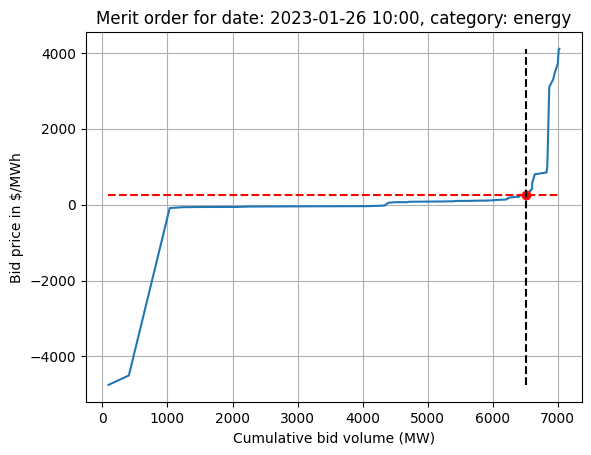

In [22]:
plot_merit_order(df_order, df_demand, filter_datetime=datetime(2023, 1, 26, 10, 0))

# 4. Final Clearing Price Function<a id=final-clearing-price-function></a>

Here I write a function that takes the demand as input and returns the final clearing price as output. The next step is to compare this calculated clearing price with the actual price on the market.

In [23]:
def get_final_clearing_price(df_order: pl.DataFrame, demand:float, filter_datetime: datetime.date)-> float:
    """Function that calculates the final clearing price from a given demand at a given time"""
    # Create a lazy, aggregated DataFrame
    df_agg = (
        df_order.filter(pl.col('datetime') == filter_datetime)
        .group_by('bid_price')
        .agg(pl.col('bid_volume').sum().alias('total_bid_volume')) # group by bid price and sum bid volume
        .sort(by='bid_price')
        .select(
            pl.cum_sum('total_bid_volume').alias('cum_bid_volume'), # get cumulated sum of bid volume
            'bid_price'
        )
        .lazy()
    )

    # Collect the data for plotting
    cum_bid_volume = df_agg.select('cum_bid_volume').collect()

    if demand <= cum_bid_volume.max().item():
        # Select smallest cumulative bid volume that satisfies demand
        volume_offer = cum_bid_volume.filter(pl.col('cum_bid_volume') > demand).min().item()

        final_clearing_price = (df_agg.filter(pl.col('cum_bid_volume') == volume_offer)
                                    .select(pl.col('bid_price'))
                                    .collect().item())
    else:
        raise ValueError(f"The demand ({demand} MW) is greater than the cumulative bid volume "
                         f"({round(cum_bid_volume.max().item(), 1)} MW) for the period.")
        
    return final_clearing_price

In [24]:
get_final_clearing_price(df_order=df_order, demand=6500, filter_datetime=datetime(2023,1,14,10))

238.0

# 5. Unit Testing the Final Clearing Price Function<a id=unit-testing></a>

In this section I will perform unit tests on the `get_final_clearing_price` function using the `pytest` and `ipytest` libraries. The tests aim to validate the behaviour of the function under different demand scenarios for a given datetime. I define a fixture to prepare a test subset of the `df_order` DataFrame, focusing on a randomly chosen datetime (19 January 2023, at 3:30 AM). The tests will check the expected clearing prices under different levels of demand and ensure that a `ValueError` is raised if the demand exceeds the available cumulative bid volume.

In [25]:
# Define the fixture decorator
@pytest.fixture
def prepare_data():
    # take a subset from df_order for a randomly chosen datetime
    df_test = df_order.filter(pl.col('datetime')==datetime(2023, 1, 19, 3, 30))
    return df_test

def test_function_get_final_clearing_price(prepare_data):    
    # Valid cases
    assert get_final_clearing_price(prepare_data, demand=2000, filter_datetime=datetime(2023, 1, 19, 3, 30)) == -60
    assert get_final_clearing_price(prepare_data, demand=3000, filter_datetime=datetime(2023, 1, 19, 3, 30)) == -45
    assert get_final_clearing_price(prepare_data, demand=5000, filter_datetime=datetime(2023, 1, 19, 3, 30)) == 85.7
    assert get_final_clearing_price(prepare_data, demand=6000, filter_datetime=datetime(2023, 1, 19, 3, 30)) == 298.0

    # Case where demand exceeds cumulative bid volume, should raise ValueError
    with pytest.raises(ValueError):
        get_final_clearing_price(df_order, demand=8000, filter_datetime=datetime(2023, 1, 19, 3, 30))

# Cell 3: Run tests
ipytest.run('-vv')

======================================= test session starts ========================================
platform darwin -- Python 3.10.10, pytest-8.2.2, pluggy-1.5.0 -- /Users/romanwolf/Code/Energy Trading Insights/energy_trading_venv/bin/python
cachedir: .pytest_cache
rootdir: /Users/romanwolf/Code/Energy Trading Insights
collecting ... collected 1 item

t_0492ce05557c4f5cab482bbbcea257d3.py::test_function_get_final_clearing_price PASSED         [100%]

======================================== 1 passed in 0.01s =========================================


<ExitCode.OK: 0>

# 6. Clearing Price for Complete Month<a id=complete-month></a>

Here I calculate the expected price for the whole demand sequence, i.e. January 2023.

In [32]:
expected_prices=[]

# iterate over date and demand with count of iterations
for idx, (date, demand) in enumerate(zip(df_demand['datetime'], df_demand['demand'])):
    print((date.strftime("%Y-%m-%d %H:%M")), f'final clearing price: ${round(get_final_clearing_price(df_order, demand, date), 2)}/MWh')
    expected_prices.append(get_final_clearing_price(df_order, demand, date))

expected_price = round(sum(expected_prices)/idx, 2)
f'Expected price over the period ${round(expected_price, 1)}/MWh.'

2023-01-01 00:00 final clearing price: $155.57/MWh
2023-01-01 00:30 final clearing price: $129.2/MWh
2023-01-01 01:00 final clearing price: $121.7/MWh
2023-01-01 01:30 final clearing price: $125.77/MWh
2023-01-01 02:00 final clearing price: $125.77/MWh
2023-01-01 02:30 final clearing price: $121.7/MWh
2023-01-01 03:00 final clearing price: $105.77/MWh
2023-01-01 03:30 final clearing price: $105.77/MWh
2023-01-01 04:00 final clearing price: $105.57/MWh
2023-01-01 04:30 final clearing price: $105.77/MWh
2023-01-01 05:00 final clearing price: $105.77/MWh
2023-01-01 05:30 final clearing price: $107.2/MWh
2023-01-01 06:00 final clearing price: $108.24/MWh
2023-01-01 06:30 final clearing price: $108.24/MWh
2023-01-01 07:00 final clearing price: $119.2/MWh
2023-01-01 07:30 final clearing price: $129.2/MWh
2023-01-01 08:00 final clearing price: $129.2/MWh
2023-01-01 08:30 final clearing price: $146.8/MWh
2023-01-01 09:00 final clearing price: $155.67/MWh
2023-01-01 09:30 final clearing price: 

2023-01-05 15:30 final clearing price: $385.81/MWh
2023-01-05 16:00 final clearing price: $399.2/MWh
2023-01-05 16:30 final clearing price: $399.2/MWh
2023-01-05 17:00 final clearing price: $409.2/MWh
2023-01-05 17:30 final clearing price: $300.87/MWh
2023-01-05 18:00 final clearing price: $225.81/MWh
2023-01-05 18:30 final clearing price: $225.81/MWh
2023-01-05 19:00 final clearing price: $240.0/MWh
2023-01-05 19:30 final clearing price: $229.2/MWh
2023-01-05 20:00 final clearing price: $240.0/MWh
2023-01-05 20:30 final clearing price: $225.81/MWh
2023-01-05 21:00 final clearing price: $220.0/MWh
2023-01-05 21:30 final clearing price: $205.87/MWh
2023-01-05 22:00 final clearing price: $200.0/MWh
2023-01-05 22:30 final clearing price: $200.0/MWh
2023-01-05 23:00 final clearing price: $155.36/MWh
2023-01-05 23:30 final clearing price: $123.26/MWh
2023-01-06 00:00 final clearing price: $179.2/MWh
2023-01-06 00:30 final clearing price: $140.2/MWh
2023-01-06 01:00 final clearing price: $11

2023-01-10 12:00 final clearing price: $299.87/MWh
2023-01-10 12:30 final clearing price: $299.87/MWh
2023-01-10 13:00 final clearing price: $306.24/MWh
2023-01-10 13:30 final clearing price: $299.97/MWh
2023-01-10 14:00 final clearing price: $299.67/MWh
2023-01-10 14:30 final clearing price: $299.87/MWh
2023-01-10 15:00 final clearing price: $306.24/MWh
2023-01-10 15:30 final clearing price: $306.24/MWh
2023-01-10 16:00 final clearing price: $299.97/MWh
2023-01-10 16:30 final clearing price: $299.87/MWh
2023-01-10 17:00 final clearing price: $280.0/MWh
2023-01-10 17:30 final clearing price: $250.0/MWh
2023-01-10 18:00 final clearing price: $279.9/MWh
2023-01-10 18:30 final clearing price: $280.0/MWh
2023-01-10 19:00 final clearing price: $280.0/MWh
2023-01-10 19:30 final clearing price: $280.0/MWh
2023-01-10 20:00 final clearing price: $280.0/MWh
2023-01-10 20:30 final clearing price: $275.0/MWh
2023-01-10 21:00 final clearing price: $250.0/MWh
2023-01-10 21:30 final clearing price: $

2023-01-16 00:00 final clearing price: $104.57/MWh
2023-01-16 00:30 final clearing price: $104.67/MWh
2023-01-16 01:00 final clearing price: $105.34/MWh
2023-01-16 01:30 final clearing price: $104.57/MWh
2023-01-16 02:00 final clearing price: $100.0/MWh
2023-01-16 02:30 final clearing price: $96.13/MWh
2023-01-16 03:00 final clearing price: $95.9/MWh
2023-01-16 03:30 final clearing price: $94.68/MWh
2023-01-16 04:00 final clearing price: $94.68/MWh
2023-01-16 04:30 final clearing price: $94.68/MWh
2023-01-16 05:00 final clearing price: $101.55/MWh
2023-01-16 05:30 final clearing price: $104.67/MWh
2023-01-16 06:00 final clearing price: $131.83/MWh
2023-01-16 06:30 final clearing price: $155.0/MWh
2023-01-16 07:00 final clearing price: $200.8/MWh
2023-01-16 07:30 final clearing price: $238.0/MWh
2023-01-16 08:00 final clearing price: $279.2/MWh
2023-01-16 08:30 final clearing price: $321.6/MWh
2023-01-16 09:00 final clearing price: $304.67/MWh
2023-01-16 09:30 final clearing price: $304

2023-01-21 13:00 final clearing price: $111.6/MWh
2023-01-21 13:30 final clearing price: $111.71/MWh
2023-01-21 14:00 final clearing price: $111.69/MWh
2023-01-21 14:30 final clearing price: $126.17/MWh
2023-01-21 15:00 final clearing price: $126.17/MWh
2023-01-21 15:30 final clearing price: $121.04/MWh
2023-01-21 16:00 final clearing price: $122.2/MWh
2023-01-21 16:30 final clearing price: $126.07/MWh
2023-01-21 17:00 final clearing price: $148.1/MWh
2023-01-21 17:30 final clearing price: $191.0/MWh
2023-01-21 18:00 final clearing price: $148.2/MWh
2023-01-21 18:30 final clearing price: $148.1/MWh
2023-01-21 19:00 final clearing price: $143.8/MWh
2023-01-21 19:30 final clearing price: $140.67/MWh
2023-01-21 20:00 final clearing price: $140.67/MWh
2023-01-21 20:30 final clearing price: $126.17/MWh
2023-01-21 21:00 final clearing price: $126.17/MWh
2023-01-21 21:30 final clearing price: $125.85/MWh
2023-01-21 22:00 final clearing price: $124.4/MWh
2023-01-21 22:30 final clearing price: 

2023-01-27 01:00 final clearing price: $105.67/MWh
2023-01-27 01:30 final clearing price: $105.67/MWh
2023-01-27 02:00 final clearing price: $105.57/MWh
2023-01-27 02:30 final clearing price: $105.47/MWh
2023-01-27 03:00 final clearing price: $72.2/MWh
2023-01-27 03:30 final clearing price: $71.9/MWh
2023-01-27 04:00 final clearing price: $83.91/MWh
2023-01-27 04:30 final clearing price: $105.57/MWh
2023-01-27 05:00 final clearing price: $105.57/MWh
2023-01-27 05:30 final clearing price: $105.67/MWh
2023-01-27 06:00 final clearing price: $110.86/MWh
2023-01-27 06:30 final clearing price: $111.15/MWh
2023-01-27 07:00 final clearing price: $111.89/MWh
2023-01-27 07:30 final clearing price: $123.2/MWh
2023-01-27 08:00 final clearing price: $138.05/MWh
2023-01-27 08:30 final clearing price: $176.88/MWh
2023-01-27 09:00 final clearing price: $165.88/MWh
2023-01-27 09:30 final clearing price: $148.2/MWh
2023-01-27 10:00 final clearing price: $148.2/MWh
2023-01-27 10:30 final clearing price: 

'Expected price over the period $193.7/MWh.'

In [24]:
f'Actual price over the period ${round(df_demand['actual_price'].mean(), 1)}/MWh.'

'Actual price over the period $221.0/MWh.'

The expected price is about \\$30/MWh lower than the actual price over the period to January 2023. The calculated actual price as a simple average of the prices is consistent with the value on the official website of the Singapore authorities ([see source](https://www.ema.gov.sg/resources/singapore-energy-statistics/chapter5)).

# 7. Comparison of Calculated and Actual Price<a id=comparison></a>

Here I focus on comparing the calculated price based on the merit order with the actual Uniform Singapore Energy Price (USEP) provided in the demand file. This comparison is crucial to understand the accuracy of my model and to identify any discrepancies between theoretical and real-world pricing in the energy market.

To visualise this comparison, I create a graph showing the actual USEP against my calculated price based on the merit order. This graphical representation allows me to easily observe and analyse any differences between the two price series.

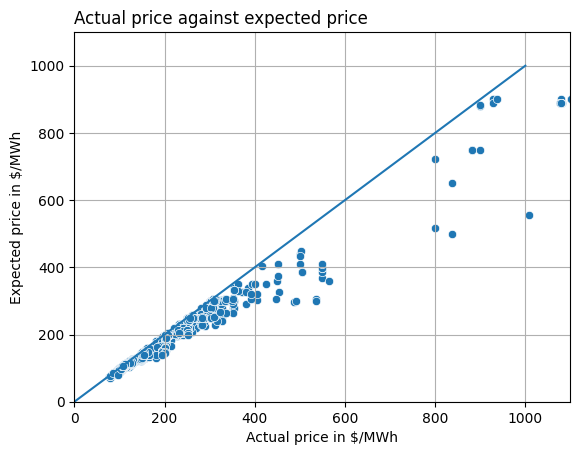

In [40]:
# create DataFrame for plotting
df_act_exp = (df_demand.with_columns(pl.Series(expected_prices).alias('exp_price'))
              .select(['actual_price', 'exp_price']))

# plot
fig, ax = plt.subplots()
sns.scatterplot(data=df_act_exp, x='actual_price', y='exp_price')
sns.lineplot(data=pl.DataFrame({'x': [0, 1000], 'y': [0, 1000]}), x='x', y='y')
ax.set_title('Actual price against expected price', loc='left')
ax.set_xlabel('Actual price in $/MWh')
ax.set_ylabel('Expected price in $/MWh')
ax.grid()
ax.set_xlim(0, 1100)
ax.set_ylim(0, 1100)

plt.show()

The visualisation shows that the expected prices calculated from the merit order data are generally lower than the actual USEP prices. The scatter points representing the expected vs. actual prices lie below the line with a slope of 1, indicating that the expected prices are consistently lower than the actual prices.

In addition, there appear to be some outliers where the difference between expected and actual prices is more pronounced. These outliers further suggest that relying solely on the merit order principle may not accurately predict final energy prices.

### Explanation
- The merit order model primarily explains the functioning of the spot market for electricity trading, but it does not cover the full range of electricity trading mechanisms. In reality, a significant proportion of electricity trading takes place through alternative channels such as over-the-counter (OTC) contracts, power purchase agreements (PPAs) and futures trading. While the merit order principle may indirectly influence the pricing of these long-term contracts, the extent of this influence is difficult to quantify precisely ([see source](https://www.next-kraftwerke.com/knowledge/what-does-merit-order-mean))
- The merit order principle doesn't describe the energy trading market as a whole, but only a subset of the electricity market design. There are other factors that affect the price of electricity, such as subsidies for fossil or renewable energy, taxes or long-term electricity contracts.
- There are often outliers where the difference between the merit order price and the actual energy price is more pronounced. These outliers can be due to unexpected events such as generator outages, transmission constraints or changes in demand.
- Constraints such as transmission limitations, network stability requirements and regulatory policies can also affect the implementation and results of the merit order principle.

# 8. SQL Implementation<a id=sql></a>

In this section I would like to highlight the implementation of the analysis performed in SQL. I chose DuckDB for its excellent performance and ease of use in a Python environment. SQL is widely used for data analysis tasks and provides a powerful, flexible and efficient way to handle and manipulate large data sets, making it an ideal choice for my analysis.

1. Database implementation:
To set up the database I:
- Created a persistent DuckDB database
- Connected to the database
- Defined the schema for the merit order and demand tables

2. SQL tasks:
- Loading data: I wrote SQL queries to load the merit order and demand data directly from the original csv files into their respective tables.
- Data cleaning in SQL: To clean the data using SQL, I created a series of queries that
    - Standardised column names to lower case with underscores
    - Converted date and period columns into a single datetime column
    - Removed all null or invalid entries
    - Resolved data type inconsistencies

This approach allowed me to take advantage of SQL's powerful data manipulation capabilities while maintaining consistency with my previous Python-based cleanup process.

In [27]:
# create persistent database
with duckdb.connect("energy.duckdb") as con:
    con.sql("""
    CREATE TABLE merit_order AS
    SELECT
        strptime(CONCAT(
            datetime, ' ',
            LPAD(CAST((period - 1) // 2 AS VARCHAR), 2, '0'), ':',
            LPAD(CAST((period - 1) % 2 * 30 AS VARCHAR), 2, '0')
        ), '%Y-%m-%d %H:%M') AS datetime, bid_price, bid_volume
    FROM
        read_csv('02_DelayedOfferStacks_Energy_01-Jan-2023 to 31-Jan-2023.csv',
            header = true,
            columns = {
                'datetime': 'DATE',
                'period': 'INT32',
                'bid_price': 'DOUBLE',
                'bid_volume': 'DOUBLE'
            },
            dateformat = '%d-%b-%Y',
            skip = 1
        )
    ORDER BY datetime;

    CREATE TABLE demand AS
    SELECT
        strptime(CONCAT(
            date, ' ',
            LPAD(CAST((period - 1) // 2 AS VARCHAR), 2, '0'), ':',
            LPAD(CAST((period - 1) % 2 * 30 AS VARCHAR), 2, '0')
        ), '%d %b %Y %H:%M') AS datetime,
        "USEP ($/MWh)" AS actual_price,
        "DEMAND (MW)" AS demand
    FROM read_csv('03_USEP_Jan-2023.csv', dateformat = '%d %B %Y')
    ORDER BY datetime;
    """)
    con.table("merit_order").show()
    con.table("demand").show()

┌─────────────────────┬───────────┬────────────┐
│      datetime       │ bid_price │ bid_volume │
│      timestamp      │  double   │   double   │
├─────────────────────┼───────────┼────────────┤
│ 2023-01-01 00:00:00 │   -4750.0 │       84.3 │
│ 2023-01-01 00:00:00 │   -4500.0 │      324.0 │
│ 2023-01-01 00:00:00 │     -90.0 │      854.0 │
│ 2023-01-01 00:00:00 │     -67.0 │      200.0 │
│ 2023-01-01 00:00:00 │     -61.0 │      280.0 │
│ 2023-01-01 00:00:00 │     -60.0 │      685.0 │
│ 2023-01-01 00:00:00 │     -50.0 │       20.0 │
│ 2023-01-01 00:00:00 │     -45.0 │      420.0 │
│ 2023-01-01 00:00:00 │     -43.0 │      215.0 │
│ 2023-01-01 00:00:00 │     -40.0 │      880.0 │
│          ·          │       ·   │         ·  │
│          ·          │       ·   │         ·  │
│          ·          │       ·   │         ·  │
│ 2023-01-02 15:30:00 │     63.57 │       80.0 │
│ 2023-01-02 15:30:00 │     63.67 │      115.0 │
│ 2023-01-02 15:30:00 │     63.77 │       10.0 │
│ 2023-01-02 15:30:0

In [28]:
# check for missing data
with duckdb.connect("energy.duckdb") as con:
    for table in ['merit_order', 'demand']:
        con.sql(f'''
        SELECT *
        FROM {table}
        WHERE datetime IS NULL;
        ''').show()

┌───────────┬───────────┬────────────┐
│ datetime  │ bid_price │ bid_volume │
│ timestamp │  double   │   double   │
├───────────┴───────────┴────────────┤
│               0 rows               │
└────────────────────────────────────┘

┌───────────┬──────────────┬────────┐
│ datetime  │ actual_price │ demand │
│ timestamp │    double    │ double │
├───────────┴──────────────┴────────┤
│              0 rows               │
└───────────────────────────────────┘



In [29]:
# find data gaps
with duckdb.connect('energy.duckdb') as con:
    con.sql("""
    WITH time_diffs AS (
        SELECT
            datetime,
            LEAD(datetime) OVER (ORDER BY datetime) - datetime AS time_diff
        FROM
            demand
    ),

    grouped_diffs AS (
        SELECT
            time_diff,
            COUNT(*) AS count
        FROM
            time_diffs
        WHERE
            time_diff IS NOT NULL
        GROUP BY
            time_diff
    )

    SELECT
        time_diff,
        count
    FROM
        grouped_diffs;
    """).show()

┌───────────┬───────┐
│ time_diff │ count │
│ interval  │ int64 │
├───────────┼───────┤
│ 00:30:00  │  1485 │
│ 01:00:00  │     1 │
└───────────┴───────┘



In [30]:
# data gap larger than 30 minute interval with datetime
with duckdb.connect('energy.duckdb') as con:
    con.sql(
        """
        WITH time_diffs AS (
        SELECT
            datetime,
            LEAD(datetime) OVER (ORDER BY datetime) AS next_datetime,
            LEAD(datetime) OVER (ORDER BY datetime) - datetime AS time_diff
        FROM
            demand
        )

        SELECT
            datetime,
            next_datetime,
            time_diff
        FROM
            time_diffs
        WHERE
            time_diff > INTERVAL 30 MINUTE
        """
    ).show()

┌─────────────────────┬─────────────────────┬───────────┐
│      datetime       │    next_datetime    │ time_diff │
│      timestamp      │      timestamp      │ interval  │
├─────────────────────┼─────────────────────┼───────────┤
│ 2023-01-22 06:00:00 │ 2023-01-22 07:00:00 │ 01:00:00  │
└─────────────────────┴─────────────────────┴───────────┘



This means that after the datetime, the next interval will be in 1 hour, indicating the gap in the data as found in the initial Python analysis.

In [31]:
with duckdb.connect('energy.duckdb') as con:
    con.sql(
        """
        SELECT * FROM demand WHERE datetime = '2023-01-22 06:00:00'
        """
    ).show()

┌─────────────────────┬──────────────┬──────────┐
│      datetime       │ actual_price │  demand  │
│      timestamp      │    double    │  double  │
├─────────────────────┼──────────────┼──────────┤
│ 2023-01-22 06:00:00 │       111.85 │ 5277.444 │
└─────────────────────┴──────────────┴──────────┘



In [32]:
# forward fill missing data
with duckdb.connect('energy.duckdb') as con:
    con.sql(
        """
        INSERT INTO demand
        VALUES (
            DATE '2023-01-22 06:00:00' + INTERVAL 30 MINUTE,
            (
                SELECT actual_price 
                FROM demand 
                WHERE datetime = '2023-01-22 06:00:00'
            ), 
            (
                SELECT demand 
                FROM demand 
                WHERE datetime = '2023-01-22 06:00:00'
            )
        );
        """
    )

I could have also connected the queries but I thought it is better readable this way.

In [33]:
# fill with researched data
with duckdb.connect('energy.duckdb') as con:
    con.sql(
        """
        INSERT INTO demand
        VALUES (
            DATE '2023-01-22 06:00:00' + INTERVAL 30 MINUTE,
            111.85,
            5277.444
        );
        """
    )